1.traindata extraction (accident, rain, day, week)-csv file? 2.testdata extraction 3.explorary: build corr matrix and some plot 4.crossvalidation for RF and Boosting (RandomizedSearchCV?)5.different measurement as R^2 6.Network? 7.Webpage?

# Final Project 4990

In this project, we will build a machine learning model to predict the travel time of a taxi trip in New York City based on the New York City 2016 Taxi data. 

## 1.Data Gathering

Our data is mainly gathered from New York City 2016 Taxi data. To detect features, we combine two more dataset including the New York weather data and traffic accident data. After extracting all features, we remove the outliers and unusual points from the data. 

### 1.1Big Query Data Extraction

#### Dataset Intrduction

In this project, we totally join three datasets(*Taxi, Weather, Collision*) to make final prediction of travel_time. According to our intuition, the travel time would be effected by weather and traffic condition, so we choose these two dataset. 

1. Taxi data

Variables selected: *pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude, pickup_datetime, dropoff_datetime, travel_time(derived from dropoff_datetime and pickup_datetime), dayname*

2. Weather data

Variables selected: *visib, prcp, fog, rain_drizzle, snow_ice_pellets, hail*

3. Traffic collision data

Variables selected: *date_of_accident, longitude, latitude, timestamp*

#### Big Query(Taxi Data & Weather)

In [1]:
import pandas as pd
import os

pd.set_option('display.max_columns', 500)
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/Users/hcy/Downloads/ecbm4040-ch3409-ab3a944860f8.json"

In [8]:
from google.cloud import bigquery
client = bigquery.Client()

## JOIN Taxi,Weather,Accident  / (note: Total number_of_accident everyday)
query = (
"""
CREATE TEMP FUNCTION RADIANS(x FLOAT64) AS (
  ACOS(-1) * x / 180
);
CREATE TEMP FUNCTION RADIANS_TO_KM(x FLOAT64) AS (
  111.045 * 180 * x / ACOS(-1)
);
CREATE TEMP FUNCTION HAVERSINE(lat1 FLOAT64, long1 FLOAT64,
                               lat2 FLOAT64, long2 FLOAT64) AS (
  RADIANS_TO_KM(
    ACOS(COS(RADIANS(lat1)) * COS(RADIANS(lat2)) *
         COS(RADIANS(long1) - RADIANS(long2)) +
         SIN(RADIANS(lat1)) * SIN(RADIANS(lat2))))
);


SELECT * FROM
(
SELECT 
     pickup_latitude,
     pickup_longitude,
     dropoff_latitude,
     dropoff_longitude,
     TIMESTAMP_DIFF( dropoff_datetime, pickup_datetime, SECOND) as travel_time,
     pickup_datetime,
     dropoff_datetime,
     FORMAT_DATE('%A',EXTRACT(DATE FROM pickup_datetime)) as dayname,
     EXTRACT (DATE FROM pickup_datetime) as date_of_year,
     EXTRACT (HOUR FROM pickup_datetime) as hour_of_day,
     CASE WHEN EXTRACT (HOUR FROM pickup_datetime) in (7,8,9,10,17,18,19,20) THEN 1
          ELSE 0
          END AS if_during_peek,
    HAVERSINE(dropoff_latitude,dropoff_longitude, dropoff_latitude, pickup_longitude) + HAVERSINE(dropoff_latitude,pickup_longitude, pickup_latitude, pickup_longitude) AS distance_in_km
    FROM `bigquery-public-data.new_york.tlc_yellow_trips_2016`
    WHERE pickup_latitude IS NOT NULL AND pickup_longitude IS NOT NULL and dropoff_longitude IS NOT NULL and (HAVERSINE(dropoff_latitude,dropoff_longitude, dropoff_latitude, pickup_longitude) + HAVERSINE(dropoff_latitude,pickup_longitude, pickup_latitude, pickup_longitude))>0.1 and EXTRACT (YEAR FROM pickup_datetime)=2016
) a
INNER JOIN
(
 select concat(year,'-',mo,'-',da) as date_of_year2,visib,prcp,fog,rain_drizzle,snow_ice_pellets,hail
 from `bigquery-public-data.noaa_gsod.gsod2016` where stn='725053'
) weather_data
on CAST(a.date_of_year AS STRING) = weather_data.date_of_year2 
LIMIT 1000000
""" )
df=pd.io.gbq.read_gbq(query,dialect='standard')
df.head()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,travel_time,pickup_datetime,dropoff_datetime,dayname,date_of_year,hour_of_day,if_during_peek,distance_in_km,date_of_year2,visib,prcp,fog,rain_drizzle,snow_ice_pellets,hail
0,40.719234,-73.990921,40.756737,-73.873405,1189,2016-05-28 03:04:14+00:00,2016-05-28 03:24:03+00:00,Saturday,2016-05-28,3,0,14.049296,2016-05-28,7.7,0.00,0,0,0,0
1,40.770714,-73.947662,40.708187,-73.915367,2155,2016-01-24 16:56:32+00:00,2016-01-24 17:32:27+00:00,Sunday,2016-01-24,16,0,9.661783,2016-01-24,7.4,1.82,1,0,1,0
2,40.774204,-73.872955,40.731628,-73.988457,2050,2016-05-30 20:13:35+00:00,2016-05-30 20:47:45+00:00,Monday,2016-05-30,20,1,14.446934,2016-05-30,7.2,1.65,1,1,0,0
3,40.769749,-73.863647,40.747921,-73.993210,2977,2016-06-28 08:55:03+00:00,2016-06-28 09:44:40+00:00,Tuesday,2016-06-28,8,1,13.323477,2016-06-28,5.7,0.54,0,1,0,0
4,40.765320,-73.979980,40.728981,-73.874580,1148,2016-06-19 01:06:14+00:00,2016-06-19 01:25:22+00:00,Sunday,2016-06-19,1,0,12.904700,2016-06-19,9.4,0.00,0,0,0,0


#### Big Query(Collision Data)

In [9]:
query = (
"""
SELECT EXTRACT (DATE FROM timestamp) as date_of_accident,longitude,latitude,timestamp
FROM `bigquery-public-data.new_york_mv_collisions.nypd_mv_collisions` 
WHERE EXTRACT (YEAR FROM timestamp) = 2016 and (EXTRACT (MONTH FROM timestamp) in (1,2,3,4,5,6))
""")
df_2=pd.io.gbq.read_gbq(query,dialect='standard')
df_2.head()

,date_of_accident,longitude,latitude,timestamp
0,2016-05-15,-73.882744,40.816864,2016-05-15 06:40:00
1,2016-02-13,-73.804000,40.760272,2016-02-13 09:50:00
2,2016-03-19,-74.009040,40.713560,2016-03-19 22:25:00
3,2016-04-28,-73.917550,40.728400,2016-04-28 00:00:00
4,2016-01-10,-73.917752,40.743046,2016-01-10 00:30:00


### 1.2 Feature Extraction

After getting original data from BigQuery, we need to extract some features for future need. The extracted features are as followings:

1. Convert Day name to one hot encoded dummy variables

2. if_during_peak : we split 24 hours into two period, one is peak period include(7,8,9,10,17,18,19,20), for which the traffic is heavy,the left is normal period, for which traffic is light.

3. Travel Distance : we use Manhattan distance to compute the length of route given the location of pickup area and dropoff area.

4. 30_minute_before_pickup : this variable is a 30 minutes earlier timestamp of pickup_datetime

5. number_of_accident : the number of accidents during the 30 minutes before pickup_datetime


In [20]:
# Convert Day name to one hot
import numpy as np

if_Monday = np.zeros([df.shape[0],1])
if_Tuesday = np.zeros([df.shape[0],1])
if_Wednesday = np.zeros([df.shape[0],1])
if_Thursday = np.zeros([df.shape[0],1])
if_Friday = np.zeros([df.shape[0],1])
if_Saturday = np.zeros([df.shape[0],1])
for i in range(df.shape[0]):
    if df['dayname'].iloc[i] == 'Monday': if_Monday[i] = 1
    elif df['dayname'].iloc[i] == 'Tuesday': if_Tuesday[i] = 1
    elif df['dayname'].iloc[i] == 'Wednesday': if_Wednesday[i] = 1
    elif df['dayname'].iloc[i] == 'Thursday': if_Thursday[i] = 1
    elif df['dayname'].iloc[i] == 'Friday': if_Friday[i] = 1
    elif df['dayname'].iloc[i] == 'Saturday': if_Saturday[i] = 1 
df['if_Monday'] = if_Monday
df['if_Tuesday'] = if_Tuesday
df['if_Wednesday'] = if_Wednesday
df['if_Thursday'] = if_Thursday
df['if_Friday'] = if_Friday
df['if_Saturday'] = if_Saturday

In [ ]:
# Compute the 30_minute_before_pickup
from datetime import timedelta
df['30_minute_before_pickup'] = df['pickup_datetime'] - timedelta(minutes=30)

### 1.3Remove Outliers

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt

First, let's have a look at the **distance** and **travel_time** to find whether there are outliers in these two variables.

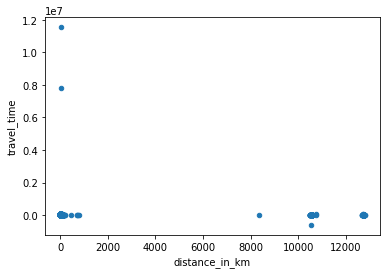

In [83]:
# Plot (distance vs. travel_time)
df.plot(x='distance_in_km',y='travel_time',kind='scatter')

From the scatter plot, we can find there might be some outliers for which **the distance_in_km** $>10000$ and **travel_time** $>10000$. It's almost impossible to happen, therefore, we remove these data. Here, the reason why we control the **travel_time** to be $< 2000$,which is roughly equal to $35$ minutes, is that we find most of our data is in this area, so we only consider these data.

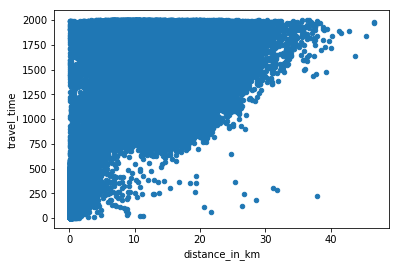

In [27]:
# Filter the outliers in 'distance' and 'travel_time'
df_filtered=df[(df['travel_time']>0) & (df['distance_in_km']<50)  & (df['travel_time']<2000)]
df_filtered.plot(x='distance_in_km',y='travel_time',kind='scatter')

After filtering the dataset, the remaining data seems more reasonable. Next, we ues similar procedure to find whether there are outliers for other variables. First, let's take a look at the **latitude** and **longitude** of the pickup and dropoff place.

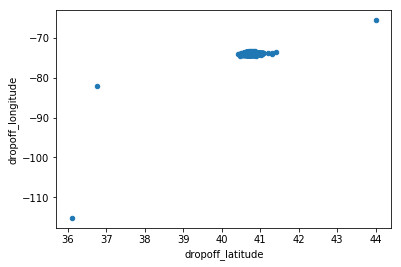

In [30]:
df_filtered.plot(x='dropoff_latitude',y='dropoff_longitude',kind='scatter')

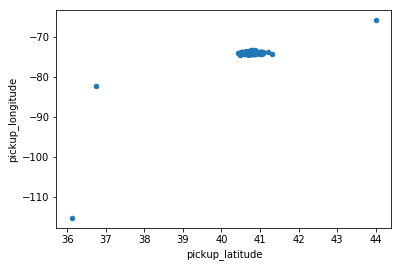

In [32]:
df_filtered.plot(x='pickup_latitude',y='pickup_longitude',kind='scatter')

From the plot, we can find some latitude and longitude are not exactly in the New York City, for which the latitude should be around $40.730610$, and longitude should be around $73.935242$. Therefore, we remove the data for which the longitude $<-80$ or $>-70$. 

Text(0.5,1,'Histogram of dropoff_longitude')

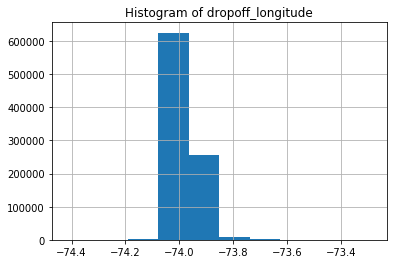

In [33]:
df_filtered_1 = df_filtered[(df_filtered['dropoff_longitude']>-80) & (df_filtered['dropoff_longitude']< -70) & (df_filtered['pickup_longitude']>-80) & (df_filtered['pickup_longitude']< -70)]
df_filtered_1['dropoff_longitude'].hist()
plt.title('Histogram of dropoff_longitude')

Then, we look at the weather variables, which include **visibility**, **fog**, **precipitation**, **snow**, **hail** 

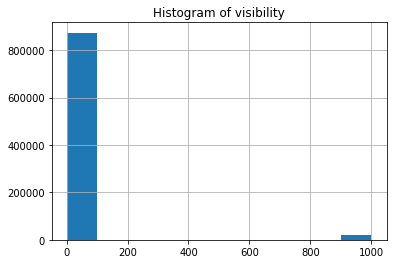

In [42]:
# Histogram of visibility 
df_filtered['visib'].hist()
plt.title('Histogram of visibility')

# Remove the outliers in visibility
df_filtered_2 = df_filtered_1[df_filtered_1['visib']<200]

By drawing the histogram plot of visibility, we can see some extreme points for which the values of visibility are more than 800, so we remove these extreme points.

Besides, some weather variables are categorical and it's hard to say there are outliers in these variables. Therefore, we use some tables to get a overview of these variables.

In [41]:
print(df_filtered_2['fog'].value_counts())
print(df_filtered_2['snow_ice_pellets'].value_counts())
print(df_filtered_2['hail'].value_counts())

0    854869
1     38762
Name: fog, dtype: int64
0    825780
1     67851
Name: snow_ice_pellets, dtype: int64
0    893631
Name: hail, dtype: int64


We found the values of variable **hail** are all the same. The reason is that the dataset only contains data from 2016 Jan to 2016 Jun, during which period there isn't hail. As a result, we remove this variable from our training set because it can't improve the performance of our model.

Till now, we finally have the clean dataset which can be used for our model !

In [79]:
# Final Dataset
df_train = df_filtered_2[['travel_time','distance_in_km','pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude','pickup_datetime','30_minute_before_pickup','if_Monday','if_Tuesday', 'if_Wednesday',
       'if_Thursday', 'if_Friday', 'if_Saturday','if_during_peek','visib','fog','prcp','snow_ice_pellets']]

In [80]:
df_train.shape

(873793, 19)

In [81]:
df_train.head()

,travel_time,distance_in_km,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,pickup_datetime,30_minute_before_pickup,if_Monday,if_Tuesday,if_Wednesday,if_Thursday,if_Friday,if_Saturday,if_during_peek,visib,fog,prcp,snow_ice_pellets
0,1189,14.049296,40.719234,-73.990921,40.756737,-73.873405,2016-05-28 03:04:14+00:00,2016-05-28 02:34:14+00:00,0.0,0.0,0.0,0.0,0.0,1.0,0,7.7,0,0.0,0
4,1148,12.904700,40.765320,-73.979980,40.728981,-73.874580,2016-06-19 01:06:14+00:00,2016-06-19 00:36:14+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0,9.4,0,0.0,0
6,1770,9.617488,40.722301,-74.008026,40.786289,-73.978149,2016-06-20 18:02:29+00:00,2016-06-20 17:32:29+00:00,1.0,0.0,0.0,0.0,0.0,0.0,1,8.9,0,0.0,0
7,1702,18.033233,40.740547,-73.998154,40.851570,-73.930237,2016-06-19 05:45:03+00:00,2016-06-19 05:15:03+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0,9.4,0,0.0,0
10,1578,7.649165,40.769279,-73.989052,40.715061,-74.008400,2016-06-26 01:25:03+00:00,2016-06-26 00:55:03+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0,9.0,0,0.0,0


In [82]:
Train_Data_csv = df_train.to_csv(r'/Users/hcy/Desktop/train_data.csv',index=False)

In [75]:
Train_Data_2_csv = df_2.to_csv(r'/Users/hcy/Desktop/train_data_2.csv',index=False)

In [77]:
Original_Data_csv = df.to_csv(r'/Users/hcy/Desktop/original_data.csv',index=False)

## 2.Exploratory Analysis

At this part, we do exploratory data analysis to see the relationship between the variable we selected and travel time. First, we can look at the correlation matrix of dataset.

In [57]:
df_train.corr()

,travel_time,distance_in_km,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,if_Monday,if_Tuesday,if_Wednesday,if_Thursday,if_Friday,if_Saturday,if_during_peek,visib,prcp
travel_time,1.000000,0.866245,-0.140807,0.325434,-0.122894,0.337474,-0.004008,-0.000586,0.002704,0.009878,0.002704,-0.018006,-0.060756,0.000867,-0.000108
distance_in_km,0.866245,1.000000,-0.166063,0.421274,-0.047239,0.403802,0.007091,-0.007682,-0.010873,-0.007274,-0.008359,-0.010925,-0.087966,0.002790,0.004694
pickup_latitude,-0.140807,-0.166063,1.000000,0.079772,0.562041,0.059488,0.009119,0.007588,0.009437,0.007228,0.006868,-0.019946,0.061123,0.001446,-0.002518
pickup_longitude,0.325434,0.421274,0.079772,1.000000,0.047163,0.410304,0.025865,0.006913,-0.003123,-0.007259,-0.007387,-0.026964,-0.002580,-0.002462,0.012611
dropoff_latitude,-0.122894,-0.047239,0.562041,0.047163,1.000000,0.294754,0.001730,0.003234,0.004710,0.004755,0.004686,-0.009789,0.032411,0.000719,-0.003748
dropoff_longitude,0.337474,0.403802,0.059488,0.410304,0.294754,1.000000,0.001861,-0.004831,-0.002073,-0.000873,0.005392,-0.011499,-0.045786,-0.000188,0.000678
if_Monday,-0.004008,0.007091,0.009119,0.025865,0.001730,0.001861,1.000000,-0.159882,-0.156484,-0.162289,-0.167963,-0.165955,0.029339,-0.113618,0.112940
if_Tuesday,-0.000586,-0.007682,0.007588,0.006913,0.003234,-0.004831,-0.159882,1.000000,-0.160042,-0.165978,-0.171782,-0.169728,0.033606,-0.072800,0.048497
if_Wednesday,0.002704,-0.010873,0.009437,-0.003123,0.004710,-0.002073,-0.156484,-0.160042,1.000000,-0.162451,-0.168131,-0.166120,0.026648,-0.046466,-0.015126
if_Thursday,0.009878,-0.007274,0.007228,-0.007259,0.004755,-0.000873,-0.162289,-0.165978,-0.162451,1.000000,-0.174368,-0.172283,0.018714,0.125076,0.013583


We can see travel time is highly correlated with the travel distance and location of pickup and dropoff, which is consistent with our expectation. Besides, the number of accidents during the 30 minutes before pickup time and if_during_peak are also good variables. It's easy to interpret because if it's during peak period the traffic is heavy,so the travel time would be longer than normal in our common sense. Similarly, if the number of accidents happend in that period is large, which means the traffic flow might stagnate, the travel time would be longer as well.

However, some variables are not as good as we expect, such as the dayname variables and weather variables. Even though these variables seem bad, we still put them in our original model. In the model selection part, we use some variable selection methods to exclude part of them to improve our model performance.

Next,we draw some plots to make it easy to know the relationship between these variables with travel time.

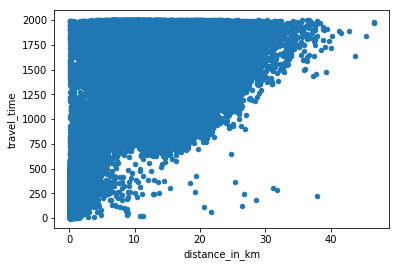

In [84]:
# plot Distance vs. Travel_time
df_train.plot(x='distance_in_km',y='travel_time',kind='scatter')

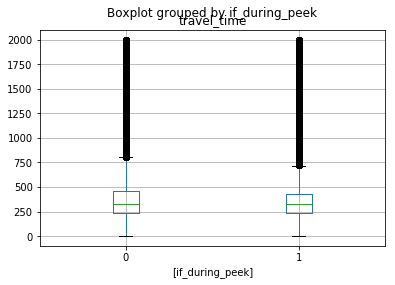

In [90]:
df_train[['travel_time','if_during_peek']].boxplot(by='if_during_peek')

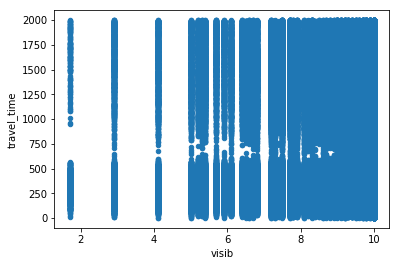

In [91]:
# plot Visibility vs. Travel_time
df_train.plot(x='visib',y='travel_time',kind='scatter')

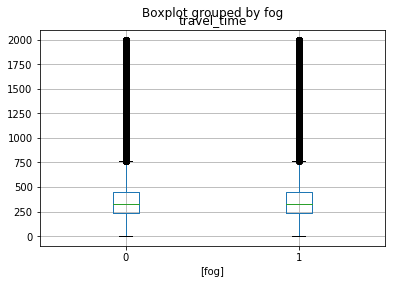

In [92]:
df_train[['travel_time','fog']].boxplot(by='fog')

From the plots showed above, we could get some general understanding of our dataset which is necessary for our future analysis and model building.

## 3.Model construction and comparision

In this part, we build different machine learning models including linear regression, random forest and boosting to predict the travel time. Compare all the models and choose the best one as our final model.  

First we devide the data into training and testing part. The training part is used to train the model and the testing part is used to evaluate the performance of the model.

In [49]:
#Train and test data split
from sklearn.model_selection import train_test_split

x = df_train[['distance_in_km','pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude','if_Monday','if_Tuesday', 'if_Wednesday',
       'if_Thursday', 'if_Friday', 'if_Saturday','if_during_peek','visib','fog','prcp','snow_ice_pellets']]
y = df_train['travel_time']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=7)

### 3.1Linear Regression

In this part, an ordinary least square model will be built and the t-test will be used to see the importance of each feature. Then we apply the shrinkage methods including Lasso and Ridge to see whether they can improve the linear model.

#### 3.1.1Ordinary Least Square

First, we build a ordinary least square model.

In [50]:
import numpy as np
from sklearn.linear_model import LinearRegression

linear_mod = LinearRegression()
linear_mod.fit(x_train,y_train)
linear_mod.score(x_test,y_test)

0.7655693658545638

Then we want to use t-test to show the importance of each variable.

In [ ]:
import scipy, scipy.stats
import statsmodels.api as sm

result = sm.OLS(y_train, x_train).fit()
result.summary()

results:

#### 3.1.2Lasso Regression

We scale the train and test data seperately to make it reasonable in the Lasso regression (also Ridge regression). For convenience to other generated data, we build a function to scale x and y.

In [1]:
#function scale_dat, Input: x, y, output: x_scaled, y_scaled
from sklearn import preprocessing

def scale_dat(x ,y):
    x_scaled = preprocessing.scale(x)
    y_scaled = y - np.mean(y)
    return x_scaled, y_scaled

In [ ]:
#scale the train and test set
x_train_scale, y_train_scale = scale_dat(x_train, y_train)
x_test_scale, y_test_scale = scale_dat(x_test, y_test)

Use cross validation to determine the optimal value of alpha:

In [ ]:
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

#Use cross validation to find the best alpha
alphas = np.linspace(0.01, 0.3, 10000)
dic_alphas = dict(alpha = alphas)
grid_search = GridSearchCV(Lasso(), dic_alphas, scoring = 'r2',n_jobs = -1,cv = 5)
grid_result = grid_search.fit(x_train_scale, y_train_scale)
alpha_opt = grid_result.best_params_
print alpha_opt

Based on the best alpha build the Lasso model:

In [ ]:
#Use the optimal alpha to build the Lasso Model
Lasso_mod = Lasso(alpha = alpha_opt)
Lasso_mod.fit(x_train_scale,y_train_scale)
Lasso_mod.score(x_test_scale,y_test_scale)

result

#### 3.1.3Ridge Regeression 

Use cross validation to determine the optimal value of alpha

In [ ]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

#Use cross validation to find the best alpha
alphas = np.linspace(0.01, 0.3, 10000)
dic_alphas = dict(alpha = alphas)
grid_search = GridSearchCV(Ridge(), dic_alphas, scoring = 'r2',n_jobs = -1,cv = 5)
grid_result = grid_search.fit(x_train_scale, y_train_scale)
alpha_opt = grid_result.best_params_
print alpha_opt

Based on the best alpha build the Ridge model

In [ ]:
#Use the optimal alpha to build the Lasso Model
Ridge_mod = Ridge(alpha = alpha_opt)
Ridge_mod.fit(x_train_scale,y_train_scale)
Ridge_mod.score(x_test_scale,y_test_scale)

In [ ]:
result

### 3.2Random Forest

Use cross validation to determine the optimal value hyper-parameters in random forest. Here we tune the hyper-parameter of n_estimators, max_depth and max_features.

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

#Use cross validation to find the best hyper-parameter
max_depth = np.linspace(1,50)
max_features = [2,3,4,5,6,7,8]
n_estimators = [100, 200, 300, 400]

dic_para = dict(max_depth = max_depth, max_features = max_features, n_estimators = n_estimators)
grid_search = GridSearchCV(RandomForestRegressor(), dic_para, scoring = 'r2', n_jobs = -1,cv = 3)
grid_result = grid_search.fit(x_train, y_train)
para_opt = grid_result.best_params_
print para_opt

Build the Random Forest based on the optimal parameters:

In [55]:
Rf_mod = RandomForestRegressor(n_estimators=100,
                                
                                
                             random_state=0)

Rf_mod.fit(x_train,y_train)
Rf_mod.score(x_test,y_test)
Rf_mod.feature_importances_

array([9.06369979e-01, 1.67350615e-02, 1.94470107e-02, 1.93405609e-02,
       1.97618824e-02, 9.37082342e-04, 1.00023625e-03, 1.06371338e-03,
       1.22152544e-03, 1.12811072e-03, 1.13803021e-03, 1.70733569e-03,
       5.30536324e-03, 3.33422952e-04, 3.93382014e-03, 5.76865054e-04])

<BarContainer object of 15 artists>

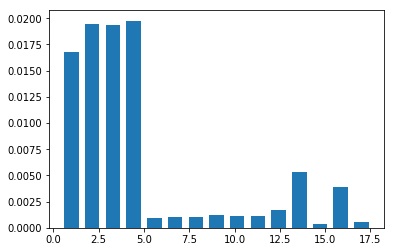

In [68]:
t = np.linspace(1,17,15)
plt.bar(t,Rf_mod.feature_importances_[1:16])

In [69]:
x.columns

Index(['distance_in_km', 'pickup_latitude', 'pickup_longitude',
       'dropoff_latitude', 'dropoff_longitude', 'if_Monday', 'if_Tuesday',
       'if_Wednesday', 'if_Thursday', 'if_Friday', 'if_Saturday',
       'if_during_peek', 'visib', 'fog', 'prcp', 'snow_ice_pellets'],
      dtype='object')

### 3.3AdaBoost

Use cross validation to determine the optimal value hyper-parameters in Adaboosting. Here we tune the hyper-parameter of n_estimators and learning_rate. There is a trade-off between the two hyperparameters which means the smaller learning rate may need a larger n. The default tree with 3 depth are used.

In [ ]:
import numpy as np
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV

#Use cross validation to find the best hyper-parameter

n_estimators = [100, 200, 300, 400]
learning_rate = 

dic_para = dict(learning_rate = learning_rate, n_estimators = n_estimators)
grid_search = GridSearchCV(AdaBoostRegressor(), dic_para, scoring = 'r2', n_jobs = -1,cv = 3)
grid_result = grid_search.fit(x_train, y_train)
para_opt = grid_result.best_params_
print para_opt

Build the Adaboost model based on the optimal parameters:

In [ ]:
Boost_mod = AdaBoostRegressor( ,
                             random_state=0)

Boost_mod.fit(x_train,y_train)
Boost_mod.score(x_test,y_test)
Boost_mod.feature_importances_

### 3.4Comparision

In [ ]:
SELECT 
     pickup_latitude,
     dropoff_longitude,
     pickup_longitude,
     dropoff_latitude,
     pickup_datetime,
     dropoff_datetime
FROM `bigquery-public-data.new_york.tlc_yellow_trips_2016`
LIMIT 100

In [ ]:
SELECT timestamp,latitude,longitude
FROM `bigquery-public-data.new_york_mv_collisions.nypd_mv_collisions`
LIMIT 100

In [ ]:
def get_accident_count(dat_1, dat_2):
    """
        @param dat_1: [start_lati, start_long, end_lati, end_long, 30min before start_time, start_time]
        @param dat_2: # [latitude, longitude, timestamp]
        
    """
    list1 = dat_1.values.tolist() # convert dat_1 to list 
    list2 = dat_2.values.tolist() # convert dat_2 to list
    
    result = [] # keep final result
    wrong_counter = 0 # count exceptions
    
    for i in range(len(list1)):
        l1 = list1[i] # current list
        
        # Convert timestamp to naive timezone
        ts1 = l1[4] # timestamp 1
        ts2 = l1[5] # timestamp 2
        l1[4] = pd.Timestamp(ts1.year, ts1.month, ts1.day, ts1.hour, ts1.minute, ts1.second)
        l1[5] = pd.Timestamp(ts2.year, ts2.month, ts2.day, ts2.hour, ts2.minute, ts2.second)
        try:
            if (l1[0] >= l1[2]):
                start_lat = l1[2]
                end_lat = l1[0]
            else:
                start_lat = l1[0]
                end_lat = l1[2]
            if (l1[1] >= l1[3]):
                start_long = l1[3]
                end_long = l1[1]
            else:
                start_long = l1[1]
                end_long = l1[3]
            start_time = l1[4]
            end_time = l1[5]
            counter = 0
            # For each list in dat_1, check all lists in dat_2
            for j in range(len(list2)):
                l2 = list2[j]
                if (start_lat <= l2[1] and end_lat >= l2[1] and start_long <= l2[2] and end_long >= l2[2] and start_time <= l2[0] and end_time >= l2[0]):
                    counter += 1
            result.append(counter)
        except:
            result.append(-1)
            print("An exception occured during execution!!!!!")
            wrong_counter += 1
            continue
    
    return result

## 4. Prediction on test set

In [ ]:
test = pd.read_csv('APM4990_final_test_data_filtered.csv')
